## Covariance Calculation from Mock Cross-Correlation Measurements

This script calculates the covariance from the 80 cross-correlation measurements from the TreePM mocks. 

This rescaled by the diagonal term from the bootstrap estimates:



In [1]:
import numpy as np
import time as time
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

# Read in bin edges
PiBin_fil = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'
PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)
PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data
# Convert bin boundaries from Mpc/h to Mpc
PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])


# Read in different realizations and arrange into suitably-shaped array
mockdir = '/Users/kheegan/lya/3d_recon/map2017/crosscorr/mocks/'
crossdir = '/Users/kheegan/lya/3d_recon/map2017/crosscorr/'

nsamp = 80
# Initialize output array to store all the bootstrap samples
XCorrSample_3dhst = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])
XCorrSample_mosdef = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])
XCorrSample_clamato = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])
XCorrSample_vuds = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])
XCorrSample_zdeep = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])

for ifil in np.arange(0,nsamp):
    
    filesuffix = "{0:03d}".format(ifil+1)
    
    XCorrTmp_zdeep=np.load(mockdir+"crosscorr/xcorrmock_zdeep_"+filesuffix+"_v4.1.npy")
    XCorrSample_zdeep[:,:,ifil] = XCorrTmp_zdeep
    
    XCorrTmp_vuds=np.load(mockdir+"crosscorr/xcorrmock_vuds_"+filesuffix+"_v4.1.npy")
    XCorrSample_vuds[:,:,ifil] = XCorrTmp_vuds
    
    XCorrTmp_clamato=np.load(mockdir+"crosscorr/xcorrmock_clamato_"+filesuffix+"_v4.1.npy")
    XCorrSample_clamato[:,:,ifil] = XCorrTmp_clamato
    
    XCorrTmp_mosdef=np.load(mockdir+"crosscorr/xcorrmock_mosdef_"+filesuffix+"_v4.1.npy")
    XCorrSample_mosdef[:,:,ifil] = XCorrTmp_mosdef
    
    XCorrTmp_3dhst=np.load(mockdir+"crosscorr/xcorrmock_3dhst_"+filesuffix+"_v4.1.npy")
    XCorrSample_3dhst[:,:,ifil] = XCorrTmp_3dhst
    
# Calculate covariances from mocks
Covar_mock_zdeep = np.cov(XCorrSample_zdeep.reshape(-1,XCorrSample_zdeep.shape[-1]))
Covar_mock_vuds = np.cov(XCorrSample_vuds.reshape(-1,XCorrSample_vuds.shape[-1]))
Covar_mock_clamato = np.cov(XCorrSample_clamato.reshape(-1,XCorrSample_clamato.shape[-1]))
Covar_mock_mosdef = np.cov(XCorrSample_mosdef.reshape(-1,XCorrSample_mosdef.shape[-1]))
Covar_mock_3dhst = np.cov(XCorrSample_3dhst.reshape(-1,XCorrSample_3dhst.shape[-1]))

np.save('covar_rawmock80_zDeep_v4.1.npy', Covar_mock_zdeep)
np.save('covar_rawmock80_vuds_v4.1.npy', Covar_mock_vuds)
np.save('covar_rawmock80_clamato_v4.1.npy', Covar_mock_clamato)
np.save('covar_rawmock80_mosdef_v4.1.npy', Covar_mock_mosdef)
np.save('covar_rawmock80_3dhst_v4.1.npy', Covar_mock_3dhst)

nbin1d = Covar_mock_zdeep.shape[0]

# Read in the bootstrap covariances, since we will use the diagonal terms to scale the 
# cross-terms
Covar_boot_zdeep = np.load(crossdir+'covar_zDeep_v4.1_n7200.npy')
Covar_boot_vuds  = np.load(crossdir+'covar_VUDS_v4.1_n7200.npy')
Covar_boot_clamato = np.load(crossdir+'covar_CLAMATO_v4.1_n7200.npy')
Covar_boot_mosdef = np.load(crossdir+'covar_MOSDEF_v4.1_n7200.npy')
Covar_boot_3dhst = np.load(crossdir+'covar_3dhst_v4.1_n7200.npy')

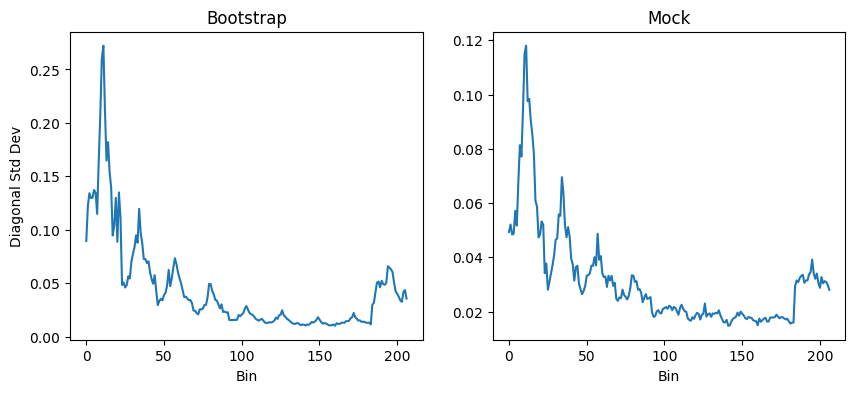

In [2]:
# Plot diagonals 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))

err_boot = np.sqrt(np.diagonal(Covar_boot_mosdef))
err_mock = np.sqrt(np.diagonal(Covar_mock_mosdef))

ax1.plot(np.arange(nbin1d), err_boot)
ax2.plot(np.arange(nbin1d), err_mock)

ax1.set_xlabel('Bin')
ax2.set_xlabel('Bin')

ax1.set_ylabel('Diagonal Std Dev')


ax1.set_title('Bootstrap')
ax2.set_title('Mock')

plt.show()

In [3]:
# Calculate correlation coefficients for both the mock and bootstrap covariances
corr_mock_zdeep = np.empty(Covar_mock_zdeep.shape)
corr_mock_vuds = np.empty(Covar_mock_zdeep.shape)
corr_mock_clamato = np.empty(Covar_mock_zdeep.shape)
corr_mock_mosdef = np.empty(Covar_mock_zdeep.shape)
corr_mock_3dhst = np.empty(Covar_mock_zdeep.shape)

corr_boot_zdeep = np.empty(Covar_mock_zdeep.shape)
corr_boot_vuds = np.empty(Covar_mock_zdeep.shape)
corr_boot_clamato = np.empty(Covar_mock_zdeep.shape)
corr_boot_mosdef = np.empty(Covar_mock_zdeep.shape)
corr_boot_3dhst = np.empty(Covar_mock_zdeep.shape)

Covar_mockscaled_zdeep = np.empty(Covar_mock_zdeep.shape)
Covar_mockscaled_vuds = np.empty(Covar_mock_zdeep.shape)
Covar_mockscaled_clamato = np.empty(Covar_mock_zdeep.shape)
Covar_mockscaled_mosdef = np.empty(Covar_mock_zdeep.shape)
Covar_mockscaled_3dhst = np.empty(Covar_mock_zdeep.shape)

for ii in np.arange(0,nbin1d-1):
    for jj in np.arange(0,nbin1d-1):
        # Calculate correlation functions
        corr_mock_zdeep[ii,jj] = Covar_mock_zdeep[ii,jj]/\
        np.sqrt(Covar_mock_zdeep[ii,ii]*Covar_mock_zdeep[jj,jj])
        corr_boot_zdeep[ii,jj] = Covar_boot_zdeep[ii,jj]/\
        np.sqrt(Covar_boot_zdeep[ii,ii]*Covar_boot_zdeep[jj,jj])
        
        corr_mock_vuds[ii,jj] = Covar_mock_vuds[ii,jj]/\
        np.sqrt(Covar_mock_vuds[ii,ii]*Covar_mock_vuds[jj,jj])
        corr_boot_vuds[ii,jj] = Covar_boot_vuds[ii,jj]/\
        np.sqrt(Covar_boot_vuds[ii,ii]*Covar_boot_vuds[jj,jj])        
        
        corr_mock_clamato[ii,jj] = Covar_mock_clamato[ii,jj]/\
        np.sqrt(Covar_mock_clamato[ii,ii]*Covar_mock_clamato[jj,jj])
        corr_boot_clamato[ii,jj] = Covar_boot_clamato[ii,jj]/\
        np.sqrt(Covar_boot_clamato[ii,ii]*Covar_boot_clamato[jj,jj])        
        
        corr_mock_mosdef[ii,jj] = Covar_mock_mosdef[ii,jj]/\
        np.sqrt(Covar_mock_mosdef[ii,ii]*Covar_mock_mosdef[jj,jj])
        corr_boot_mosdef[ii,jj] = Covar_boot_mosdef[ii,jj]/\
        np.sqrt(Covar_boot_mosdef[ii,ii]*Covar_boot_mosdef[jj,jj])
        
        corr_mock_3dhst[ii,jj] = Covar_mock_3dhst[ii,jj]/\
        np.sqrt(Covar_mock_3dhst[ii,ii]*Covar_mock_3dhst[jj,jj])
        corr_boot_3dhst[ii,jj] = Covar_boot_3dhst[ii,jj]/\
        np.sqrt(Covar_boot_3dhst[ii,ii]*Covar_boot_3dhst[jj,jj])
        
        # Rescale off-diagonals of mock covariances by diagonal term of bootstrap covariances
        Covar_mockscaled_zdeep[ii,jj] = corr_mock_zdeep[ii,jj] * \
        np.sqrt(Covar_boot_zdeep[ii,ii]*Covar_boot_zdeep[jj,jj])

        Covar_mockscaled_vuds[ii,jj] = corr_mock_vuds[ii,jj] * \
        np.sqrt(Covar_boot_vuds[ii,ii]*Covar_boot_vuds[jj,jj])
        
        Covar_mockscaled_clamato[ii,jj] = corr_mock_clamato[ii,jj] * \
        np.sqrt(Covar_boot_clamato[ii,ii]*Covar_boot_clamato[jj,jj])

        Covar_mockscaled_mosdef[ii,jj] = corr_mock_mosdef[ii,jj] * \
        np.sqrt(Covar_boot_mosdef[ii,ii]*Covar_boot_mosdef[jj,jj])      
        
        Covar_mockscaled_3dhst[ii,jj] = corr_mock_3dhst[ii,jj] * \
        np.sqrt(Covar_boot_3dhst[ii,ii]*Covar_boot_3dhst[jj,jj])        
        
np.save('covar_mock80_zDeep_v4.1.npy', Covar_mockscaled_zdeep)
np.save('covar_mock80_vuds_v4.1.npy', Covar_mockscaled_vuds)
np.save('covar_mock80_clamato_v4.1.npy', Covar_mockscaled_clamato)
np.save('covar_mock80_mosdef_v4.1.npy', Covar_mockscaled_mosdef)
np.save('covar_mock80_3dhst_v4.1.npy', Covar_mockscaled_3dhst)        

        

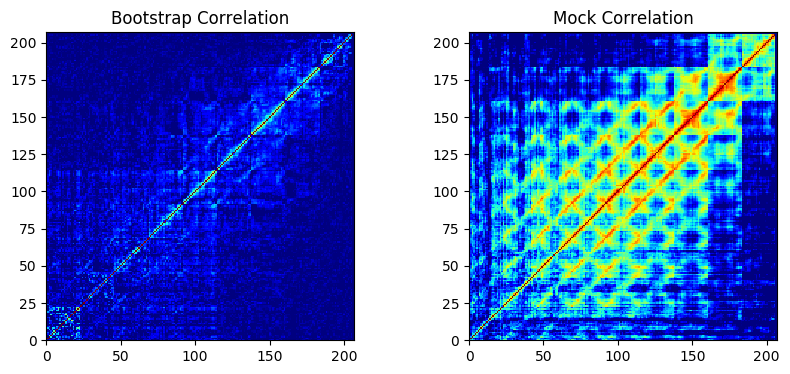

In [4]:
    
# Plot the correlation matrices for comparison
xmesh, ymesh = np.meshgrid(np.arange(nbin1d+1), np.arange(nbin1d+1))

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))

ax1.pcolormesh(xmesh, ymesh, corr_boot_mosdef, cmap='jet', vmin=0., vmax=1)
ax1.set_aspect('equal')
#ax1.set_xlim(0, 100)
#ax1.set_ylim(0,100)
ax1.set_title('Bootstrap Correlation')

ax2.pcolormesh(xmesh, ymesh, corr_mock_mosdef, cmap='jet', vmin=0., vmax=1)
ax2.set_aspect('equal')
#ax2.set_xlim(0, 100)
#ax2.set_ylim(0,100)
ax2.set_title('Mock Correlation')

plt.show()

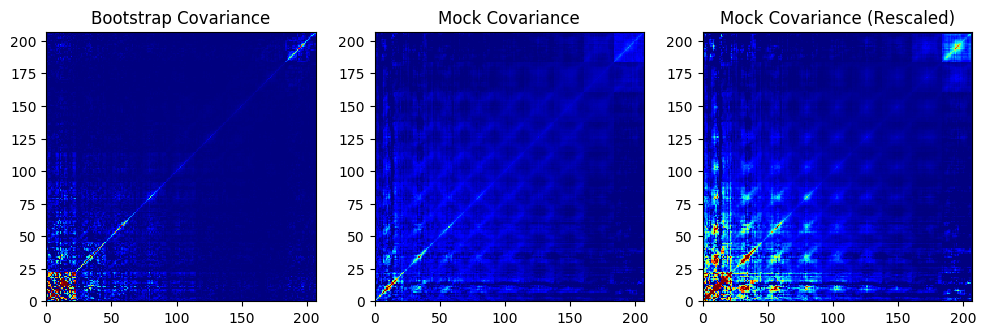

In [7]:
# Plot the covariance matrices for comparison
xmesh, ymesh = np.meshgrid(np.arange(nbin1d+1), np.arange(nbin1d+1))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,3.5))

max_bin = 207

ax1.pcolormesh(xmesh, ymesh, Covar_boot_mosdef, cmap='jet', vmin=0., vmax=0.005)
ax1.set_aspect('equal')
ax1.set_xlim(0, max_bin)
ax1.set_ylim(0,max_bin)
ax1.set_title('Bootstrap Covariance')

ax2.pcolormesh(xmesh, ymesh, Covar_mock_mosdef, cmap='jet', vmin=0., vmax=0.005)
ax2.set_aspect('equal')
ax2.set_xlim(0, max_bin)
ax2.set_ylim(0,max_bin)
ax2.set_title('Mock Covariance')

ax3.pcolormesh(xmesh, ymesh, Covar_mockscaled_mosdef, cmap='jet', vmin=0., vmax=0.005)
ax3.set_aspect('equal')
ax3.set_xlim(0, max_bin)
ax3.set_ylim(0,max_bin)
ax3.set_title('Mock Covariance (Rescaled)')

plt.show()